# Init

In [92]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim
import powerlaw

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from gensim.models import Word2Vec, KeyedVectors
from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [66]:
from sklearn import preprocessing

In [67]:
from scoring import scoring

In [68]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

## Youtube

In [70]:
input_path = 'example_graphs/youtube.mat'
youtube = loadmat(input_path)
A = youtube['network']
N = A.shape[0]

In [71]:
A

<1138499x1138499 sparse matrix of type '<class 'numpy.float64'>'
	with 5980886 stored elements in Compressed Sparse Column format>

In [72]:
d = [l[0] for l in A.sum(axis=1).tolist()]

alpha=  1.5323916189591387   sigma=  0.000498959026077326


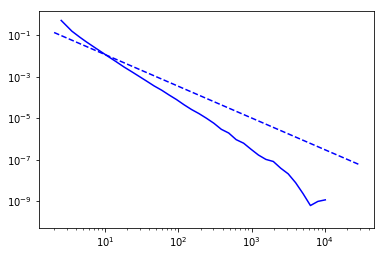

In [73]:
fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Random Projection

In [74]:
# projection method: choose from Gaussian and Sparse
# input matrix: choose from adjacency and transition matrix
# alpha adjusts the weighting of nodes according to their degree
def randne_projection(A, q=3, dim=128, projection_method='gaussian', input_matrix='adj', alpha=None):
    assert input_matrix == 'adj' or input_matrix == 'trans'
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    if input_matrix == 'adj':
        M = A
    else:
        N = A.shape[0]
        normalizer = spdiags(np.squeeze(1.0 / csc_matrix.sum(A, axis=1) ), 0, N, N)
        M = normalizer @ A
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)
    Y = transformer.fit(M)
    # Random projection for A
    if alpha is not None:
        Y.components_ = Y.components_ @ spdiags( \
                        np.squeeze(np.power(csc_matrix.sum(A, axis=1), alpha)), 0, N, N)
    cur_U = transformer.transform(M)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        # print (type(M), M.shape)
        cur_U = M @ cur_U
        # print (type(cur_U), U.shape)
        U_list.append(cur_U)
    return U_list

In [75]:
# When weights is None, concatenate instead of linearly combines the embeddings from different powers of A
def randne_merge(U_list, weights, normalization=False):
    dense_U_list = [_U.todense() for _U in U_list] if type(U_list[0]) == csc_matrix else U_list
    _U_list = [normalize(_U, norm='l2', axis=1) for _U in dense_U_list] if normalization else dense_U_list

    if weights is None:
        return np.concatenate(_U_list, axis=1)
    U = np.zeros_like(_U_list[0])
    for cur_U, weight in zip(_U_list, weights):
        U += cur_U * weight
    U = preprocessing.scale(U.todense())
    # U = normalize(U.todense(), norm='l2', axis=1)
    return U

In [76]:
# A is always the adjacency matrix
# the choice between adj matrix and trans matrix is decided in the conf
def randne_wrapper(A, conf):
    U_list = randne_projection(A,
                               q=len(conf['weights']),
                               dim=conf['dim'],
                               projection_method=conf['projection_method'],
                               input_matrix=conf['input_matrix'],
                               alpha=conf['alpha'],
    )
    U = randne_merge(U_list, conf['weights'], conf['normalization'])
    return U

# Configuration for Easy Grid Search

In [77]:
def get_emb_filename(prefix, conf):
    return prefix + '-dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix'] + ',normalization=' + str(conf['normalization']) \
        + ',weights=' + (','.join(map(str, conf['weights'])) if conf['weights'] is not None else 'None') \
        + ',alpha=' + (str(conf['alpha']) if 'alpha' in conf else '') \
        + ',C=' + (str(conf['C']) if 'alpha' in conf else '1.0') \
        + '.mat'

# Grid Search for Degree Normalization

In [78]:
keys = ['projection_method', 'input_matrix', 'weights', 'normalization', 'dim', 'alpha', 'C']

all_dims = [128]
# all_alphas = [0.0, -0.7, -0.75, -0.8, -1.0]
all_alphas = [0.0]

all_alpha_conf_raw = itertools.product(
    # projection method
    ['sparse'],
    # input matrix
    ['trans'],
    # weights
    [
        [0.0, 0.0, 1.0, 4.0, 4.0, 0],

    ],
    # normalization
    [True],
    # dimensionality
    all_dims,
    # alpha
    all_alphas,
    # C
    # [0.1, 0.5, 1.0]
    [0.1]
)
all_alpha_conf = [{key: val for key, val in zip(keys, conf)} for conf in all_alpha_conf_raw]
len(all_alpha_conf)

1

In [79]:
all_alpha_conf

[{'projection_method': 'sparse',
  'input_matrix': 'trans',
  'weights': [0.0, 0.0, 1.0, 4.0, 4.0, 0],
  'normalization': True,
  'dim': 128,
  'alpha': 0.0,
  'C': 0.1}]

Start grid search:

In [29]:
%%time
df = pd.DataFrame()

prefix = 'result/youtube'
for conf in all_alpha_conf:
    # print (conf)
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
#     print ('Evaluating on the classification task...')
#     f1_scores = scoring(
#         [
#             "--emb", emb_filename,
#             "--network","example_graphs/flickr.mat",
#             "--num-shuffles", "5",
#             "--debug",
#             "--C", str(conf['C']),
#         ],
#         )
#     # see https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
#     df = df.append(pd.Series({**conf, **f1_scores}), ignore_index=True)
#     df.to_csv('result/flickr-scores.txt', sep='\t', index=False, header=True)

df

result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,1.0,4.0,4.0,0,alpha=0.0,C=0.1.mat
CPU times: user 1min 55s, sys: 44.7 s, total: 2min 39s
Wall time: 45.9 s


# Intelligent Hyperparameter Search

In [80]:
import optuna

In [81]:
prefix = 'result/youtube'

In [82]:
input_path

'example_graphs/youtube.mat'

In [45]:
%%time
order_range = 2
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 0.1, 64.0) for order in range(order_range)]
    # alpha = trial.suggest_uniform('alpha', -1.0, 0.0)
    alpha = 0.0
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0] + weights,
        'normalization': True,
        'dim': 128,
        'alpha': alpha,
        'C': 0.1
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = randne_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network", input_path,
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "1",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['micro'] - f1_scores[0]['macro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.9306033401680134,0.7855613154838695,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24849045627613942, 'macro': 0.1906634111809259}
-------------------


[I 2019-03-27 18:29:06,193] Finished trial#0 resulted in value: -0.4391538674570653. Current best value is -0.4391538674570653 with parameters: {'weight0': 1.9306033401680134, 'weight1': 0.7855613154838695}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,13.895130786051396,0.25800859784906927,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23287948863161623, 'macro': 0.17284296788455403}
-------------------


[I 2019-03-27 18:29:34,275] Finished trial#1 resulted in value: -0.4057224565161702. Current best value is -0.4391538674570653 with parameters: {'weight0': 1.9306033401680134, 'weight1': 0.7855613154838695}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,11.754163246721353,0.6737097489853193,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2273760365964487, 'macro': 0.1670475386072341}
-------------------


[I 2019-03-27 18:30:02,876] Finished trial#2 resulted in value: -0.39442357520368276. Current best value is -0.4391538674570653 with parameters: {'weight0': 1.9306033401680134, 'weight1': 0.7855613154838695}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.31536996138395723,11.225924569044901,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26395156889258, 'macro': 0.20430340348751044}
-------------------


[I 2019-03-27 18:30:31,104] Finished trial#3 resulted in value: -0.4682549723800904. Current best value is -0.4682549723800904 with parameters: {'weight0': 0.31536996138395723, 'weight1': 11.225924569044901}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,54.085429413920764,0.41852121971264467,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23398102752498492, 'macro': 0.16628570489965552}
-------------------


[I 2019-03-27 18:30:59,377] Finished trial#4 resulted in value: -0.40026673242464045. Current best value is -0.4682549723800904 with parameters: {'weight0': 0.31536996138395723, 'weight1': 11.225924569044901}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.26950788237571827,0.8204674428970194,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23621661567780386, 'macro': 0.1800332043152195}
-------------------


[I 2019-03-27 18:31:27,806] Finished trial#5 resulted in value: -0.41624981999302335. Current best value is -0.4682549723800904 with parameters: {'weight0': 0.31536996138395723, 'weight1': 11.225924569044901}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,37.15019969108399,2.8265772314309303,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2366459956737963, 'macro': 0.17188581608317913}
-------------------


[I 2019-03-27 18:31:56,432] Finished trial#6 resulted in value: -0.4085318117569754. Current best value is -0.4682549723800904 with parameters: {'weight0': 0.31536996138395723, 'weight1': 11.225924569044901}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,13.37691175199798,54.683746798061186,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2716119401731559, 'macro': 0.22054892513496885}
-------------------


[I 2019-03-27 18:32:24,079] Finished trial#7 resulted in value: -0.49216086530812475. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,35.85948978638227,36.3538527330805,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26597703013737334, 'macro': 0.20438112321550908}
-------------------


[I 2019-03-27 18:32:53,003] Finished trial#8 resulted in value: -0.47035815335288245. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.2705423701573221,1.2199312519623362,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25923034076633084, 'macro': 0.1893466090566389}
-------------------


[I 2019-03-27 18:33:21,430] Finished trial#9 resulted in value: -0.4485769498229697. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.6970454383345015,10.158000839176356,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2614356013113951, 'macro': 0.20884162158055375}
-------------------


[I 2019-03-27 18:33:50,506] Finished trial#10 resulted in value: -0.47027722289194884. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,7.230456259212632,11.929634085614932,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27177170442244886, 'macro': 0.2109390751675381}
-------------------


[I 2019-03-27 18:34:18,694] Finished trial#11 resulted in value: -0.482710779589987. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.688487522441537,0.12487128467656634,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.236420120513778, 'macro': 0.18040156429185297}
-------------------


[I 2019-03-27 18:34:47,420] Finished trial#12 resulted in value: -0.416821684805631. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.11182106441956531,53.81006811728262,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25833476924975973, 'macro': 0.19184725464879757}
-------------------


[I 2019-03-27 18:35:15,557] Finished trial#13 resulted in value: -0.4501820238985573. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,3.735543115700468,3.6368665219996505,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.263725989423971, 'macro': 0.20610118898142135}
-------------------


[I 2019-03-27 18:35:44,627] Finished trial#14 resulted in value: -0.46982717840539234. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.7366596929115052,27.181751975875933,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26035641764161566, 'macro': 0.19931709260596361}
-------------------


[I 2019-03-27 18:36:13,110] Finished trial#15 resulted in value: -0.4596735102475793. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,20.472026300794877,4.8186948666699765,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24462475274134285, 'macro': 0.18815408801306674}
-------------------


[I 2019-03-27 18:36:41,358] Finished trial#16 resulted in value: -0.4327788407544096. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,5.858162561602363,14.105008099280886,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27169162968209476, 'macro': 0.20892530867849926}
-------------------


[I 2019-03-27 18:37:09,422] Finished trial#17 resulted in value: -0.48061693836059405. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,6.992023225733816,25.364592692654558,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26469183932214074, 'macro': 0.21446138375687154}
-------------------


[I 2019-03-27 18:37:37,717] Finished trial#18 resulted in value: -0.4791532230790123. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,3.841409138089311,57.106314028594205,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26237724412083036, 'macro': 0.19842348761381792}
-------------------


[I 2019-03-27 18:38:05,830] Finished trial#19 resulted in value: -0.4608007317346483. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,21.084626804904534,8.360637274226189,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2546142888503749, 'macro': 0.19953106161945885}
-------------------


[I 2019-03-27 18:38:33,754] Finished trial#20 resulted in value: -0.45414535046983373. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,8.410555195921681,5.903891389656235,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2615355790238797, 'macro': 0.20924572352679158}
-------------------


[I 2019-03-27 18:39:01,254] Finished trial#21 resulted in value: -0.4707813025506713. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.1659246323821473,18.375356038398156,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26057486655438106, 'macro': 0.20213443275888013}
-------------------


[I 2019-03-27 18:39:29,859] Finished trial#22 resulted in value: -0.4627092993132612. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,4.321640307364385,1.898795404765545,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24400209291737074, 'macro': 0.18981761360335123}
-------------------


[I 2019-03-27 18:39:58,334] Finished trial#23 resulted in value: -0.433819706520722. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,23.529375900471916,63.47101840985989,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26794508963591196, 'macro': 0.2061760677395923}
-------------------


[I 2019-03-27 18:40:27,355] Finished trial#24 resulted in value: -0.47412115737550425. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,11.32045516162109,19.25726394218458,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2678358907777052, 'macro': 0.21036267296660427}
-------------------


[I 2019-03-27 18:40:55,472] Finished trial#25 resulted in value: -0.47819856374430947. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.20582949210476,41.853699514892384,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2612595455260541, 'macro': 0.20870072469311904}
-------------------


[I 2019-03-27 18:41:23,880] Finished trial#26 resulted in value: -0.4699602702191732. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,36.1968883660036,6.709944428399751,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24739366392771103, 'macro': 0.1901341452409795}
-------------------


[I 2019-03-27 18:41:52,047] Finished trial#27 resulted in value: -0.4375278091686905. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,62.31959084570741,30.20869122708725,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25906971506801696, 'macro': 0.20328699731787525}
-------------------


[I 2019-03-27 18:42:20,476] Finished trial#28 resulted in value: -0.4623567123858922. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.9940058246376537,2.0601298845905744,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26315262841329257, 'macro': 0.20222460394961672}
-------------------


[I 2019-03-27 18:42:48,939] Finished trial#29 resulted in value: -0.4653772323629093. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,16.77886630443247,14.60300288624019,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2645952840357144, 'macro': 0.2084059535255138}
-------------------


[I 2019-03-27 18:43:16,914] Finished trial#30 resulted in value: -0.47300123756122825. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,9.43085051683478,0.22073588108964926,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.22790269705663782, 'macro': 0.17158334054386234}
-------------------


[I 2019-03-27 18:43:45,412] Finished trial#31 resulted in value: -0.39948603760050017. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,6.082343505140505,3.8209677131998214,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25892489280002456, 'macro': 0.20589248707015728}
-------------------


[I 2019-03-27 18:44:14,183] Finished trial#32 resulted in value: -0.46481737987018185. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.4454975372207504,43.11854117626768,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2623815458352819, 'macro': 0.20101068397466762}
-------------------


[I 2019-03-27 18:44:42,402] Finished trial#33 resulted in value: -0.46339222980994954. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,14.171383838453947,8.234042100015504,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26288033340776457, 'macro': 0.2035045842121831}
-------------------


[I 2019-03-27 18:45:10,596] Finished trial#34 resulted in value: -0.46638491761994766. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,26.86657698242683,23.360320675477613,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2603705977547836, 'macro': 0.20980702054448166}
-------------------


[I 2019-03-27 18:45:38,868] Finished trial#35 resulted in value: -0.4701776182992653. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,48.64085284255245,1.3833411369908275,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.22709508657449787, 'macro': 0.1661589209334802}
-------------------


[I 2019-03-27 18:46:07,364] Finished trial#36 resulted in value: -0.39325400750797807. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.4204085007517302,0.4180577020424674,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24358135905080688, 'macro': 0.18303666676746053}
-------------------


[I 2019-03-27 18:46:35,546] Finished trial#37 resulted in value: -0.4266180258182674. Current best value is -0.49216086530812475 with parameters: {'weight0': 13.37691175199798, 'weight1': 54.683746798061186}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,5.340763253722823,12.928263849787449,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27177678884054823, 'macro': 0.22158455973369492}
-------------------


[I 2019-03-27 18:47:03,803] Finished trial#38 resulted in value: -0.4933613485742432. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.413905094075786,17.540837987093436,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26474122384061155, 'macro': 0.2023654481251124}
-------------------


[I 2019-03-27 18:47:32,834] Finished trial#39 resulted in value: -0.467106671965724. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,4.579234726663569,35.66937321306282,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26224455778150396, 'macro': 0.19876443879956587}
-------------------


[I 2019-03-27 18:48:01,214] Finished trial#40 resulted in value: -0.46100899658106986. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.17479625296757587,0.8800649683357313,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24702498884941584, 'macro': 0.17961800406403364}
-------------------


[I 2019-03-27 18:48:28,907] Finished trial#41 resulted in value: -0.4266429929134495. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.9063802787293687,63.13093218905736,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2676648014911677, 'macro': 0.20078040332580882}
-------------------


[I 2019-03-27 18:48:58,304] Finished trial#42 resulted in value: -0.46844520481697655. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,11.075984843578556,11.689009255631133,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2661431202464258, 'macro': 0.20839304994019237}
-------------------


[I 2019-03-27 18:49:27,857] Finished trial#43 resulted in value: -0.47453617018661814. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.46150353484205,2.762001027988156,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2605150512110781, 'macro': 0.20233008298193178}
-------------------


[I 2019-03-27 18:49:59,905] Finished trial#44 resulted in value: -0.4628451341930099. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.948646783455389,5.212638824576329,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2598053873288688, 'macro': 0.20429956682913217}
-------------------


[I 2019-03-27 18:50:30,237] Finished trial#45 resulted in value: -0.464104954158001. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,29.85690502621858,9.057961439651555,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.243449792065615, 'macro': 0.18194988623533515}
-------------------


[I 2019-03-27 18:51:02,388] Finished trial#46 resulted in value: -0.42539967830095016. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,15.081677829540833,46.44229569722354,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27379274033873785, 'macro': 0.21373980689026842}
-------------------


[I 2019-03-27 18:51:34,791] Finished trial#47 resulted in value: -0.4875325472290063. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.3490225619770098,0.18447806416233647,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23558221478703648, 'macro': 0.17587123148239314}
-------------------


[I 2019-03-27 18:52:06,769] Finished trial#48 resulted in value: -0.4114534462694296. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,46.651212272412,31.515324156675305,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26096503826481293, 'macro': 0.19730954171083712}
-------------------


[I 2019-03-27 18:52:37,389] Finished trial#49 resulted in value: -0.45827457997565. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.8770817483377928,0.5748127946148419,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25435200456028595, 'macro': 0.19465767724709226}
-------------------


[I 2019-03-27 18:53:07,556] Finished trial#50 resulted in value: -0.4490096818073782. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,5.956965591862842,3.246241293927946,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25942722871293017, 'macro': 0.19862114253324556}
-------------------


[I 2019-03-27 18:53:35,998] Finished trial#51 resulted in value: -0.4580483712461757. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,8.486389946544142,4.19382655256981,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2520060977589811, 'macro': 0.19783542603599183}
-------------------


[I 2019-03-27 18:54:06,984] Finished trial#52 resulted in value: -0.4498415237949729. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.9677597039605895,21.705408782632453,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26540849035378394, 'macro': 0.2113816499523479}
-------------------


[I 2019-03-27 18:54:35,366] Finished trial#53 resulted in value: -0.47679014030613187. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,17.717913447359404,7.5305095412559595,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2549797514352131, 'macro': 0.1991054679232368}
-------------------


[I 2019-03-27 18:55:04,112] Finished trial#54 resulted in value: -0.4540852193584499. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,4.905735365276068,15.708489275793559,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2624519298018349, 'macro': 0.2004893760630718}
-------------------


[I 2019-03-27 18:55:33,370] Finished trial#55 resulted in value: -0.46294130586490667. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.14988421694863271,10.664808623979486,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26072628689431004, 'macro': 0.1964924782871805}
-------------------


[I 2019-03-27 18:56:01,405] Finished trial#56 resulted in value: -0.4572187651814905. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,30.347062827144313,1.399776853942818,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23540021235654293, 'macro': 0.17734881701321512}
-------------------


[I 2019-03-27 18:56:30,029] Finished trial#57 resulted in value: -0.41274902936975805. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.9601927371000714,49.79988926519926,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2633750399705357, 'macro': 0.20526267842264448}
-------------------


[I 2019-03-27 18:56:58,269] Finished trial#58 resulted in value: -0.46863771839318014. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,12.347612131650608,2.039151502300448,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23961777113933402, 'macro': 0.18592053015002366}
-------------------


[I 2019-03-27 18:57:26,384] Finished trial#59 resulted in value: -0.42553830128935766. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,3.435086719743606,6.057415001188518,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27372188867502933, 'macro': 0.21270588109768537}
-------------------


[I 2019-03-27 18:57:55,195] Finished trial#60 resulted in value: -0.48642776977271474. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,0.6481549916661561,14.065772392474875,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26277660998836483, 'macro': 0.20403762705903306}
-------------------


[I 2019-03-27 18:58:23,375] Finished trial#61 resulted in value: -0.4668142370473979. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,42.298640697064144,38.25023503709872,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2682582213579689, 'macro': 0.21249023993975127}
-------------------


[I 2019-03-27 18:58:52,233] Finished trial#62 resulted in value: -0.4807484612977202. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,7.317292618699426,0.1007576248954095,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.22892740349907473, 'macro': 0.1708371679538431}
-------------------


[I 2019-03-27 18:59:20,625] Finished trial#63 resulted in value: -0.3997645714529178. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,19.391694054584853,27.300892382963823,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2711483812936646, 'macro': 0.20810733868602124}
-------------------


[I 2019-03-27 18:59:48,838] Finished trial#64 resulted in value: -0.47925571997968586. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,14.799728688138519,50.18229118613734,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2751060202638213, 'macro': 0.2125314129714112}
-------------------


[I 2019-03-27 19:00:16,464] Finished trial#65 resulted in value: -0.4876374332352325. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,9.395566325809712,63.020455134306886,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.269750259704584, 'macro': 0.21051001266532698}
-------------------


[I 2019-03-27 19:00:45,044] Finished trial#66 resulted in value: -0.480260272369911. Current best value is -0.4933613485742432 with parameters: {'weight0': 5.340763253722823, 'weight1': 12.928263849787449}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,24.85741391537784,54.54445271104637,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.28169302686773084, 'macro': 0.2177753458373667}
-------------------


[I 2019-03-27 19:01:12,948] Finished trial#67 resulted in value: -0.4994683727050976. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,63.63619215897651,21.330989912074713,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2446176041294302, 'macro': 0.18903799124870072}
-------------------


[I 2019-03-27 19:01:40,665] Finished trial#68 resulted in value: -0.4336555953781309. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,24.1452563531796,36.32643258735928,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2685970045059877, 'macro': 0.20723266203953608}
-------------------


[I 2019-03-27 19:02:08,259] Finished trial#69 resulted in value: -0.47582966654552383. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,5.09361439198307,12.98270016863094,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.269080561901172, 'macro': 0.20873084128905206}
-------------------


[I 2019-03-27 19:02:36,176] Finished trial#70 resulted in value: -0.4778114031902241. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,11.196089782489528,28.245854546793357,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26589106997558204, 'macro': 0.2043221139756303}
-------------------


[I 2019-03-27 19:03:04,625] Finished trial#71 resulted in value: -0.47021318395121237. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,36.24104981311536,16.602227537132308,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2540648373914856, 'macro': 0.19928782496559996}
-------------------


[I 2019-03-27 19:03:32,153] Finished trial#72 resulted in value: -0.4533526623570856. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,7.6513710326238815,9.90703855086409,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.263285913293699, 'macro': 0.20141416409622104}
-------------------


[I 2019-03-27 19:04:00,187] Finished trial#73 resulted in value: -0.46470007738992003. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.2034237737308278,57.58909047855865,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27012732930046685, 'macro': 0.20521588047542627}
-------------------


[I 2019-03-27 19:04:28,439] Finished trial#74 resulted in value: -0.4753432097758931. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,55.046690522100775,32.59356589652278,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25657295533401325, 'macro': 0.19491169158343877}
-------------------


[I 2019-03-27 19:04:56,425] Finished trial#75 resulted in value: -0.45148464691745205. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,4.058648623853674,23.96909506910999,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2667359910885874, 'macro': 0.20643953757173608}
-------------------


[I 2019-03-27 19:05:24,405] Finished trial#76 resulted in value: -0.47317552866032353. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,22.463262339122707,4.401580259894963,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24356379471827358, 'macro': 0.18453864042780546}
-------------------


[I 2019-03-27 19:05:51,667] Finished trial#77 resulted in value: -0.42810243514607904. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,6.436326846026357,19.756865773296028,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2650841358188433, 'macro': 0.20610673230952445}
-------------------


[I 2019-03-27 19:06:20,115] Finished trial#78 resulted in value: -0.47119086812836775. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,9.869422380877754,0.35013382907764634,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23765645008877645, 'macro': 0.17905485062137427}
-------------------


[I 2019-03-27 19:06:47,468] Finished trial#79 resulted in value: -0.4167113007101507. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,30.496288219491404,2.398084288921537,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24090274100263986, 'macro': 0.17850927849266876}
-------------------


[I 2019-03-27 19:07:15,294] Finished trial#80 resulted in value: -0.4194120194953086. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,13.110282405320783,43.20584192236338,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26938239901126393, 'macro': 0.20553189603458658}
-------------------


[I 2019-03-27 19:07:43,603] Finished trial#81 resulted in value: -0.4749142950458505. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,16.295812981339868,0.9685585330520098,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.22736893939279212, 'macro': 0.16716571852399786}
-------------------


[I 2019-03-27 19:08:13,049] Finished trial#82 resulted in value: -0.39453465791679. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.621478448253486,5.26488018044188,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26724211153575217, 'macro': 0.20568250086447268}
-------------------


[I 2019-03-27 19:08:44,261] Finished trial#83 resulted in value: -0.4729246124002249. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,3.3544262663400777,3.272771639311042,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26280937016229244, 'macro': 0.20440340283933814}
-------------------


[I 2019-03-27 19:09:15,249] Finished trial#84 resulted in value: -0.46721277300163055. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,52.62376675969782,7.595377565010409,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.24392852247868693, 'macro': 0.1861517242559021}
-------------------


[I 2019-03-27 19:09:46,214] Finished trial#85 resulted in value: -0.430080246734589. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,5.421873755904726,56.61544259589336,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2627732256340691, 'macro': 0.20183306137202006}
-------------------


[I 2019-03-27 19:10:17,381] Finished trial#86 resulted in value: -0.46460628700608914. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,39.71419704080995,24.855435014165323,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26686421866022986, 'macro': 0.20407378255840514}
-------------------


[I 2019-03-27 19:10:48,239] Finished trial#87 resulted in value: -0.470938001218635. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,17.376450854552047,12.124763909668593,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2620120080775947, 'macro': 0.2063843640439861}
-------------------


[I 2019-03-27 19:11:20,920] Finished trial#88 resulted in value: -0.4683963721215808. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,28.17923232539726,40.08185352825961,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.26715626004886867, 'macro': 0.20535021669884224}
-------------------


[I 2019-03-27 19:11:52,059] Finished trial#89 resulted in value: -0.4725064767477109. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,2.678160761044289,31.16704060322829,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2588066069339275, 'macro': 0.20399397206167544}
-------------------


[I 2019-03-27 19:12:23,041] Finished trial#90 resulted in value: -0.4628005789956029. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,19.648506057702022,1.6649950675805336,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2310589636891142, 'macro': 0.17295734063842014}
-------------------


[I 2019-03-27 19:12:54,194] Finished trial#91 resulted in value: -0.4040163043275343. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,25.74256399692058,0.6832889285594063,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2344822848928851, 'macro': 0.1773971432960322}
-------------------


[I 2019-03-27 19:13:25,805] Finished trial#92 resulted in value: -0.4118794281889173. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.1492963667076093,9.543348964185082,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.25614064359754635, 'macro': 0.20213478795600429}
-------------------


[I 2019-03-27 19:13:56,726] Finished trial#93 resulted in value: -0.45827543155355066. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,10.19132018470097,49.01765771182562,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2624711564128463, 'macro': 0.20097254868890388}
-------------------


[I 2019-03-27 19:14:29,507] Finished trial#94 resulted in value: -0.46344370510175015. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,7.8918042824196455,63.55085323329632,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2676751473187468, 'macro': 0.20538757007525996}
-------------------


[I 2019-03-27 19:15:01,636] Finished trial#95 resulted in value: -0.47306271739400674. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,4.321405211346742,18.20581094405614,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27465916705743876, 'macro': 0.21110355456609534}
-------------------


[I 2019-03-27 19:15:33,265] Finished trial#96 resulted in value: -0.48576272162353407. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,32.34988383764302,6.152710317197763,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.23578585780377312, 'macro': 0.18248252410079577}
-------------------


[I 2019-03-27 19:16:04,549] Finished trial#97 resulted in value: -0.4182683819045689. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,6.8137951929308285,15.688884511241225,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.27445302769407615, 'macro': 0.2089057505285549}
-------------------


[I 2019-03-27 19:16:36,966] Finished trial#98 resulted in value: -0.48335877822263107. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


result/youtube-dim=128,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.9964096238604683,7.162337551783782,alpha=0.0,C=0.1.mat
Train percent: 0.01
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.2632387591425238, 'macro': 0.2012572302989456}
-------------------


[I 2019-03-27 19:17:08,663] Finished trial#99 resulted in value: -0.4644959894414694. Current best value is -0.4994683727050976 with parameters: {'weight0': 24.85741391537784, 'weight1': 54.54445271104637}.


CPU times: user 3h 20min 35s, sys: 31min 43s, total: 3h 52min 18s
Wall time: 48min 30s


In [84]:
study.best_params

{'weight0': 24.85741391537784, 'weight1': 54.54445271104637}

In [85]:
study.best_trial

FrozenTrial(number=67, state=<TrialState.COMPLETE: 1>, value=-0.4994683727050976, datetime_start=datetime.datetime(2019, 3, 27, 19, 0, 45, 46540), datetime_complete=datetime.datetime(2019, 3, 27, 19, 1, 12, 942079), params={'weight0': 24.85741391537784, 'weight1': 54.54445271104637}, user_attrs={}, system_attrs={'_number': 67}, intermediate_values={}, params_in_internal_repr={'weight0': 24.85741391537784, 'weight1': 54.54445271104637}, trial_id=67)

In [39]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 1.0, 4.50120, 18.40175, 47.48506],
        'normalization': True,
        'dim': 256,
        'alpha': 0.0,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(A, conf)
    savemat(emb_filename, {'emb': U}, do_compression=True)
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network", input_path,
        "--num-shuffles", "5",
        # "--all",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
f1_scores

result/youtube-dim=256,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0,4.5012,18.40175,47.48506,alpha=0.0,C=0.1.mat
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 256
-------------------
Train percent: 0.01
Average score: {'micro': 0.31099512731292567, 'macro': 0.24981226909591422}
-------------------
Train percent: 0.02
Average score: {'micro': 0.32388816422086947, 'macro': 0.27198636029180284}
-------------------
Train percent: 0.03
Average score: {'micro': 0.3319900610711921, 'macro': 0.2813639152505155}
-------------------
Train percent: 0.04
Average score: {'micro': 0.33670541602761433, 'macro': 0.2873289815497726}
-------------------
Train percent: 0.05
Average score: {'micro': 0.34170727654691013, 'macro': 0.29226327728860724}
-------------------
Train percent: 0.06
Aver

In [ ]:
# Credit for this function to: https://stackoverflow.com/a/43682143/2873090
def sparse_memory_usage(mat):
    try:
        return mat.data.nbytes + mat.indptr.nbytes + mat.indices.nbytes
    except AttributeError:
        return -1

In [147]:
%%time
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0,1.0,1.0,1.0,1.0,24.139057351134923,44.32797824046076],
        'normalization': True,
        'dim': 512,
        'alpha': -0.02659,
        'C': 0.1
    }
U = randne_wrapper(A, conf)

CPU times: user 4min 51s, sys: 4min 1s, total: 8min 53s
Wall time: 3min 19s


In [28]:
%%time
f1_scores = scoring(
    [
        "--network","example_graphs/youtube.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "0.1",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
    U
)
f1_scores

Namespace(C=0.1, adj_matrix_name='network', debug=True, emb=None, label_matrix_name='group', network='example_graphs/youtube.mat', normalize=False, num_shuffles=5, training_percents=['1', '2', '3', '4', '5', '6', '7', '8', '9']) None
Load embeddings from memory...
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.309646692350164, 'macro': 0.25361260190436086}
-------------------
Train percent: 0.02
Average score: {'micro': 0.32635506535108905, 'macro': 0.27652739413663197}
-------------------
Train percent: 0.03
Average score: {'micro': 0.32892490377242956, 'macro': 0.2846946928450685}
-------------------
Train percent: 0.04
Average score: {'micro': 0.33148471878091906, 'macro': 0.29040778655441646}
-------------------
Train percent: 0.05
Averag

In [87]:
U

array([[-0.01878078, -0.02487135, -0.01454269, ...,  0.12410945,
         0.09795101,  0.03428491],
       [-1.37674529, -0.3355484 , -0.41898202, ...,  0.00890674,
         0.52029712,  0.2901723 ],
       [ 0.09210759,  0.08537119,  0.1813336 , ...,  0.09846803,
        -0.32845812,  0.52923152],
       ...,
       [-0.19914584,  0.30287828,  0.16690143, ...,  0.08082668,
        -0.11716159, -0.3776042 ],
       [-0.05567786,  0.09250092,  0.01056317, ...,  0.5074915 ,
        -0.18146308, -0.12311208],
       [-0.05365108,  0.20006468,  0.05204284, ...,  0.22332999,
        -0.04367316, -0.11455044]])

# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/youtube.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output example_graphs/youtube.emb &

In [93]:
dw_emb_fname = "/home/hcchen/deepwalk/example_graphs/youtube.emb"

In [89]:
%%time
dw_f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk/example_graphs/youtube.emb",
        "--network","example_graphs/youtube.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)]
)
dw_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.3890587646683936, 'macro': 0.29775917427116827}
-------------------
Train percent: 0.02
Average score: {'micro': 0.404245559931934, 'macro': 0.32972711070678207}
-------------------
Train percent: 0.03
Average score: {'micro': 0.409583652436324, 'macro': 0.33966583026679187}
-------------------
Train percent: 0.04
Average score: {'micro': 0.4133770370671854, 'macro': 0.34712085200250364}
-------------------
Train percent: 0.05
Average score: {'micro': 0.41649142624113944, 'macro': 0.3504262452849559}
-------------------
Train percent: 0.06
Average score: {'micro': 0.42048366447683067, 'macro': 0.3540361232440502}
-------------------
Train percent: 0.07
Average score: {'micro': 0.4234425301859689,

Load DeepWalk embeddings:

In [97]:
model = KeyedVectors.load_word2vec_format(dw_emb_fname, binary=False)

In [99]:
N = len(model.vocab)
%time dw_emb = np.asarray([model[str(node)] for node in range(N)])

CPU times: user 4.29 s, sys: 572 ms, total: 4.86 s
Wall time: 4.86 s


In [101]:
dw_emb.shape

(1138499, 128)

## Embedding Space Properties

In [179]:
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import euclidean_distances

We can take a specific node (maybe chosen based on its degree) and plot the distribution of the L2 distance between its embeddings and all other nodes. Can we see a difference here? Is it different from Flickr or Blogcatalog?

First take a high degree node:

In [149]:
ind = 3

In [131]:
A[ind]

<1x1138499 sparse matrix of type '<class 'numpy.float64'>'
	with 2753 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space for DeepWalk and random projection:

In [173]:
dw_l2_distance_high = euclidean_distances([dw_emb[ind]], dw_emb)

In [174]:
rp_l2_distance_high = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


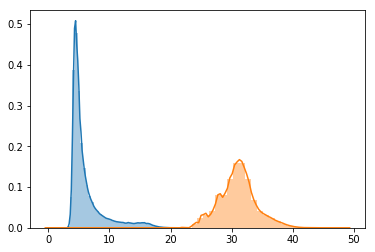

In [175]:
sns.distplot(dw_l2_distance_high)
sns.distplot(rp_l2_distance_high)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


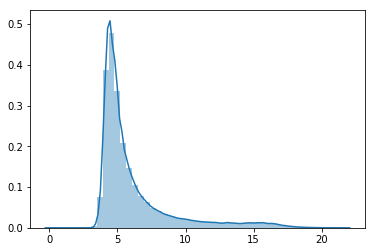

In [176]:
sns.distplot(dw_l2_distance_high)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


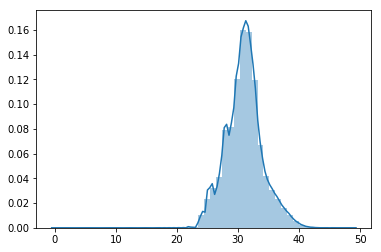

In [177]:
sns.distplot(rp_l2_distance_high)

Then take a mid-degree node:

In [157]:
ind = 141240

In [158]:
A[ind]

<1x1138499 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space:

In [159]:
dw_dist_mid = euclidean_distances([dw_emb[ind]], dw_emb)

In [162]:
rp_dist_mid = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


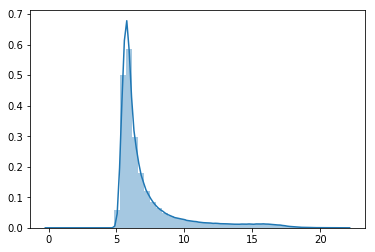

In [164]:
sns.distplot(dw_dist_mid)

Then take a low-degree node:

In [166]:
ind = 5

In [167]:
A[ind]

<1x1138499 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space:

In [168]:
dw_dist_low = euclidean_distances([dw_emb[ind]], dw_emb)

In [169]:
rp_dist_low = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


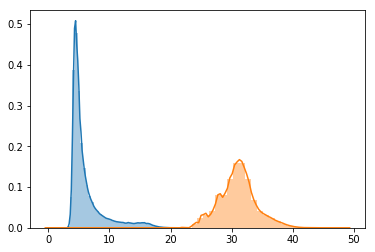

In [170]:
sns.distplot(dw_dist_low)
sns.distplot(rp_dist_low)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


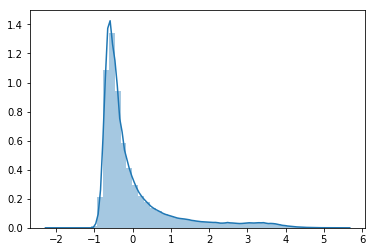

In [190]:
sns.distplot(scale(np.squeeze(dw_dist_low)))

In [194]:
scale(np.squeeze(rp_dist_low))

array([-6.9260682 , -2.16892542, -1.73990025, ..., -1.28078008,
        1.23636194, -0.26458407])

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


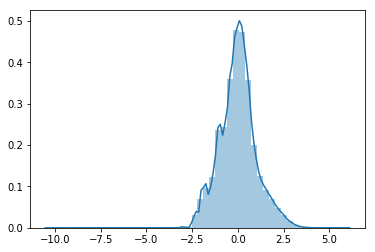

In [191]:
sns.distplot(scale(np.squeeze(rp_dist_low)))

# Run RandNE

In [54]:
import sys
sys.path.insert(0, "/home/hcchen/RandNE-Python/src")
from randne import main

In [60]:
%%time
randne_U = main(
    [
        "--input", "/home/hcchen/fast-random-projection/example_graphs/youtube.mat",
        "--use-trans-matrix",
        "-q", "3",
        "-d", "512",
        "--weights", "1", "100", "1000"
    ]
)

Namespace(input='/home/hcchen/fast-random-projection/example_graphs/youtube.mat', matfile_variable_name='network', order=3, output=None, representation_size=512, use_trans_matrix=True, weights=['1', '100', '1000'])
CPU times: user 1min 37s, sys: 33 s, total: 2min 10s
Wall time: 1min 5s


In [ ]:
cd ~/RandNE-Python/ &&
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/youtube.mat \
--output /home/hcchen/fast-random-projection/result/youtube-randne-emb.mat \
--use-trans-matrix -q 3 -d 256 --weights 1 100 1000

In [ ]:
%%time
randne_f1_scores = scoring(
    [
        "--network","example_graphs/youtube.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
    randne_U
)
randne_f1_scores

Load embeddings from memory...
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09


In [64]:
randne_f1_scores

[defaultdict(float,
             {'micro': 0.2765139592527134,
              'macro': 0.22038621055641175,
              'training': 0.01}),
 defaultdict(float,
             {'micro': 0.27455825473488205,
              'macro': 0.2329201327765466,
              'training': 0.02}),
 defaultdict(float,
             {'micro': 0.27432136109478283,
              'macro': 0.2397390237539545,
              'training': 0.03}),
 defaultdict(float,
             {'micro': 0.2630509561605239,
              'macro': 0.23802864267677312,
              'training': 0.04}),
 defaultdict(float,
             {'micro': 0.24699097210171522,
              'macro': 0.22890528127375723,
              'training': 0.05}),
 defaultdict(float,
             {'micro': 0.24529753505476876,
              'macro': 0.22038541854297686,
              'training': 0.06}),
 defaultdict(float,
             {'micro': 0.25374461166135004,
              'macro': 0.21914894075035402,
              'training': 0.07}),
 defaultdi